# Approximate every non linear functions in world 3 with linear combinations of tanh functions
- Started 19/11

## Get every non linear functions

In [1]:
import json
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
# Load definitions
with open("../../world3/pyworld3/pyworld3/pyworld3/definitions.json","r") as d:
    dico_vars = json.load(d)

In [3]:
# Get functions list
with open ("../../world3/pyworld3/pyworld3/pyworld3/functions_table_world3.json") as table:
    functions = json.load(table)

# Interpolate all functions like in the pyworld3 code (function set_<sector>_table_functions in each sector)
from scipy.interpolate import interp1d
for f in functions:
        f['fun'] = interp1d(f['x.values'], f['y.values'], # Interpolate from x y points
                            bounds_error=False,  # If x outide of bounds, no error but ...
                            fill_value=(f['y.values'][0], f['y.values'][-1]))# ... take values of y bounds

In [4]:
def plot_non_linear_fun(num):
    ## Create an x range, a little bit outside x bounds:
    xmin, xmax = (functions[num]['x.values'][i] for i in (0,-1))
    xmin, xmax = xmin - (xmax-xmin)/10, xmax + (xmax-xmin)/10
    xvals = np.linspace(xmin, xmax, num=100)

    # Plot x and interpolated functions results
    plt.plot(xvals, functions[num]['fun'](xvals))

    # Plot x and y labels
    xname = functions[num]['x.name'].lower()
    yname = functions[num]['y.name'].lower()
    plt.xlabel(xname)
    plt.ylabel(yname)

    # Print sector, names, definitions, and definitions of names included in definition
    print('----- Sector',functions[num]['sector'],'------')
    names = xname.split('/') + yname.split('/')

    for n in names:
        print(n, ':', dico_vars[n])
        for nn in dico_vars:
            if nn in re.split(' |,',dico_vars[n]):
                print(nn, dico_vars[nn])
fun_dict = {f['y.name']: f for f in functions}

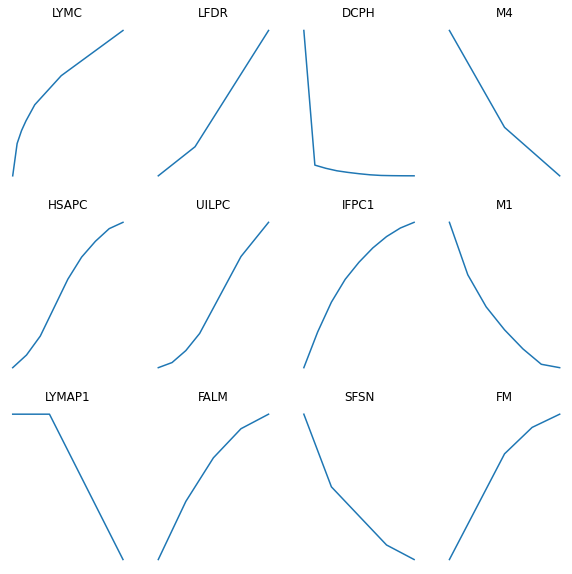

In [11]:
Nf = 12
import random
fun_sample = random.sample(functions, Nf)
c = 4
plt.plot
fig, axes = plt.subplots(Nf//c, c, figsize = (10, 10))
for i, f in enumerate(fun_sample):
    ax = axes[i//c, i%c]
    ax.plot(f['x.values'], f['y.values'])
    ax.set_title(f['y.name'])
    ax.set_axis_off()

# main values


In [6]:
fe = fun_dict['FSAFC']
f = fe['fun']

In [7]:
# Train values
T = 100
delta = 0.2

xvals = fe['x.values']
minx, maxx = min(xvals), max(xvals)
diff = maxx - minx
minx, maxx = minx - delta*diff, maxx + delta*diff


X = np.random.uniform(minx, maxx, T)
Y = f(X)
Xt = np.sort(X)
Yt = Y[np.argsort(X)]

# Tanh network

In [8]:
# Network
N = 20
scale = 2
biais = 1
BX = np.vstack((biais*np.ones(T), Xt)).T

W_in = np.random.uniform(-1, 1, (2, N))

In [9]:
# Learn
gamma = 0
S = np.tanh(np.dot(BX, W_in))
pinv = np.dot(S, np.linalg.inv(np.eye(N)*gamma + np.dot(S.T, S)))
W_out = np.dot(np.linalg.pinv(S), Yt)
OUT = np.dot(S, W_out)

In [109]:
# Test
t = 100
x = np.linspace(minx, maxx, t)
b = np.ones(t)
bx = np.vstack((b, x)).T
s = np.tanh(np.dot(bx, W_in))
y = f(x)
out = np.dot(s, W_out)

(0.0, 0.042)

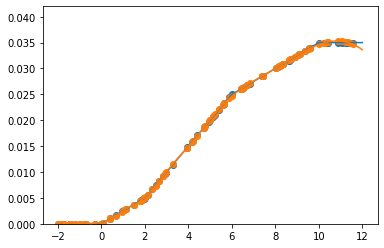

In [110]:
# Plot
plt.plot(x, y)
plt.plot(x, out)
plt.scatter(Xt, Yt)
plt.scatter(Xt, OUT)
plt.ylim([min(y)-0.2*abs(min(y)), max(y) + 0.2*abs(max(y))])

## With derivatives

In [111]:
from scipy.signal import savgol_filter
f_0 = Yt #savgol_filter(Yt, 3, 2)

Ye = np.hstack((2*f_0[0] - f_0[1], f_0, 2*f_0[-1] - f_0[-2]))
Xe = np.hstack((2*Xt[0] - Xt[1], Xt, 2*Xt[-1] - Xt[-2]))
f_1_l = (Ye[1:-1] - Ye[0:-2])/(Xe[1:-1] - Xe[0:-2])
f_1_r = (Ye[2:] - Ye[1:-1])/(Xe[2:] - Xe[1:-1])
f_1 = 1/2*(f_1_l + f_1_l)

f_1_e = np.hstack((2*f_1[0] - f_1[1], f_1, 2*f_1[-1] - f_1[-2]))
f_2_l = (f_1_e[1:-1] - f_1_e[0:-2])/(Xe[1:-1] - Xe[0:-2])
f_2_r = (f_1_e[2:] - f_1_e[1:-1])/(Xe[2:] - Xe[1:-1])
f_2 = 1/2*(f_2_l + f_2_r)
plt.plot(Xt, f_0)
plt.plot(Xt, f_1)
plt.plot(Xt, f_2)

In [112]:
ii = (f_2 > 00.1) + (f_2 < -00.1)
f_0 = f_2[ii]
f_1 = f_2[ii]
f_2 = f_2[ii]
a = np.mean(np.sqrt((f_0**2*f_2-2*f_0*f_1**2)/(-2*f_2)))
(-2*f_2)
a

/home/achille/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/achille/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

# With optimizer

In [113]:
from scipy.optimize import least_squares, minimize

In [114]:
def f(params, Xt):
    alpha, biais, w, theta = params
    return biais + alpha*np.tanh(w*(Xt + theta))
def residuals(params, Xt, Yt):
    return np.mean((f(params, Xt) - Yt)**2)
to_optmize = lambda params: residuals(params, Xt, Yt)

In [115]:
# Init params
alpha_0 = Yt[-1] - Yt[0]
biais_0 = np.mean(Yt)
w_0 = 2*np.pi/(Xt[-1] - Xt[0])
theta_0 = - np.mean(Xt)
params_0 = alpha_0, biais_0, w_0, theta_0

In [116]:
opt_ls = least_squares(to_optmize, params_0)
opt_min = minimize(to_optmize, params_0)
plt.plot(Xt, Yt, label='True')
plt.plot(Xt, f(params_0, Xt), label='Init')
plt.plot(Xt, f(opt_ls.x, Xt), label='least squares')
plt.plot(Xt, f(opt_min.x, Xt), label='Scipy minimize')
plt.legend()

 ## Tour par tour train

In [117]:
def truncate(x, low, high):
    x_low = np.vstack((low* np.ones(x.shape), x))
    x_low = np.max(x_low, axis=0)
    x_high = np.vstack((high* np.ones(x.shape), x_low))
    return np.min(x_high, axis=0)

In [118]:
# init
w = np.random.uniform(4, 5)
theta = np.random.uniform(-6, 1)
alpha = np.random.uniform(0.2, 1)
biais =  np.random.uniform(0.5, 2)

In [131]:
# ALPHA BIAIS
plt.plot(Xt, Yt)
sigma_u = np.tanh(w*Xt + theta)
to_reg = np.vstack((sigma_u, np.ones(T)))
alpha, biais = np.dot(np.linalg.pinv(to_reg).T, Yt)

plt.plot(Xt, alpha*np.tanh(w*Xt + theta) + biais)

sigma_u = (Yt - biais)/alpha

# TRUNCATION
# trunc_indices = (sigma_u < 1)*(sigma_u > -1)
# trunc_sigma_u = sigma_u[trunc_indices]
# trunc_X = Xt[trunc_indices]
# trunc_Y = Yt[trunc_indices]
# trunc_T = len(trunc_X)
# trunc_u = np.arctanh(trunc_sigma_u)

trunc_sigma_u = truncate(sigma_u, -0.999, 0.999)
trunc_X = Xt
trunc_Y = Yt
trunc_T = len(trunc_X)
trunc_u = np.arctanh(trunc_sigma_u)

# WEIGHT THETA
plt.plot(Xt, Yt)
plt.plot(Xt, alpha*np.tanh(w*Xt + theta) + biais)
to_reg = np.vstack((trunc_X, np.ones(trunc_T)))
w, theta = np.dot(np.linalg.pinv(to_reg).T, trunc_u) 

plt.plot(Xt, alpha*np.tanh(w*Xt + theta) + biais)

## Stochasitc gradient

In [343]:
train_time = 200
batch_size = 20
p_deriv = 0.2
MAX_TRUC = 2

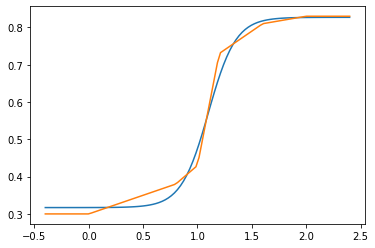

In [345]:
w = np.random.uniform(4, 5)
theta = np.random.uniform(-6, 1)
alpha = np.random.uniform(0.2, 1)
biais =  np.random.uniform(0.5, 2)

for i in range(train_time):
    # LOOP
    indices = np.random.choice(range(T), batch_size)
    Yt = Y[indices]
    Yt = Yt[np.argsort(X[indices])]
    Xt = np.sort(X[indices])

    # Forward
    Yc = alpha*np.tanh(w*Xt + theta) + biais

    # Backward
    diff = Yt - Yc
    deriv_biais = 1
    deriv_alpha = 1*np.tanh(w*Xt+theta)        
    deriv_w = alpha/np.cosh(w*Xt+theta)**2*Xt
    deriv_theta = alpha/np.cosh(w*Xt+theta)**2

    # plt.plot(Xt, alpha*np.tanh(w*Xt + theta) + biais)
    # plt.plot(Xt, Yt)

    biais += np.mean(diff*p_deriv/deriv_biais)
    alpha += np.mean(diff*p_deriv/deriv_alpha)
    
    to_add_w = (diff*p_deriv/deriv_w)[np.argmax(abs(deriv_w))]
    if to_add_w < MAX_TRUC:
        w += to_add_w
    to_add_theta = (diff*p_deriv/deriv_theta)[np.argmax(abs(deriv_theta))]
    if to_add_theta < MAX_TRUC:
        theta += to_add_theta

plt.plot(x, alpha*np.tanh(w*x + theta) + biais)
plt.plot(x, y)